In [ ]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cd /content/drive/MyDrive/ECE1786/A2/

/content/drive/MyDrive/ECE1786/A2


## 3.1

In [ ]:
data = pd.read_csv("data.tsv", sep="\t")
data.head()

,text,label
0,"smart and alert , thirteen conversations about...",1
1,"color , musical bounce and warm seas lapping o...",1
2,it is not a mass-market entertainment but an u...,1
3,a light-hearted french film about the spiritua...,1
4,my wife is an actress has its moments in looki...,1


In [ ]:
data.shape

(10000, 2)

In [ ]:
data[data["label"]==1]['text'].values[10:20]

array(['the bland outweighs the nifty , and cletis tout never becomes the clever crime comedy it thinks it is . ',
       'directed by david twohy with the same great eye for eerie understatement that he brought to pitch black . ',
       "it's a very tasteful rock and roll movie . you could put it on a coffee table anywhere . ",
       "provides the kind of 'laugh therapy' i need from movie comedies -- offbeat humor , amusing characters , and a happy ending . after seeing 'analyze that , ' i feel better already . ",
       'worth a look by those on both sides of the issues , if only for the perspective it offers , one the public rarely sees . ',
       'watching the film is like reading a times portrait of grief that keeps shifting focus to the journalist who wrote it . ',
       'despite these annoyances , the capable clayburgh and tambor really do a great job of anchoring the characters in the emotional realities of middle age . ',
       "it's a good thing that woolly mammoths are 

In [ ]:
data[data["label"]==0]['text'].values[0:10]

array(['the movie begins in the past where a young boy named sam attempts to save celebi from a hunter . ',
       'emerging from the human psyche and showing characteristics of abstract expressionism , minimalism and russian constructivism , graffiti removal has secured its place in the history of modern art while being created by artists who are unconscious of their artistic achievements . ',
       "spurning her mother's insistence that she get on with her life , mary is thrown out of the house , rejected by joe , and expelled from school as she grows larger with child . ",
       "amitabh can't believe the board of directors and his mind is filled with revenge and what better revenge than robbing the bank himself , ironic as it may sound . ",
       'she , among others excentricities , talks to a small rock , gertrude , like if she was alive . ',
       'this gives the girls a fair chance of pulling the wool over their eyes using their sexiness to poach any last vestige of common s

## 3.2

In [ ]:
from sklearn.model_selection import train_test_split
X = data["text"].values
Y = data['label'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True, random_state=1,stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=1, stratify=Y_train)

In [ ]:
print(np.unique(Y_train,return_counts=True))
print(np.unique(Y_val, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([0, 1]), array([3200, 3200]))
(array([0, 1]), array([800, 800]))
(array([0, 1]), array([1000, 1000]))


In [ ]:
duplicate = 0
for i in X_train:
  if i in X_val or i in X_test:
    print("same sample!!!", i)
    duplicate += 1
if duplicate == 0:
  print("No same sample in more than one set")

No same sample in more than one set


In [ ]:
train = pd.DataFrame(X_train, columns=['text'])
train['label'] = Y_train
val = pd.DataFrame(X_val, columns=['text'])
val['label'] = Y_val
test = pd.DataFrame(X_test, columns=['text'])
test['label'] = Y_test

In [ ]:
subset_data_0 = data[data['label']==0][0:25]
subset_data_1 = data[data['label']==1][0:25]
subset_data = pd.concat([subset_data_0, subset_data_1], ignore_index=True)
np.unique(subset_data['label'].values,return_counts=True)

(array([0, 1]), array([25, 25]))

In [ ]:
train.to_csv('train.tsv', sep='\t')
val.to_csv('validation.tsv', sep='\t')
test.to_csv('test.tsv', sep='\t')
subset_data.to_csv('overfit.tsv', sep='\t')

## 3.3

In [ ]:
# TextDataset is Described in Section 3.3 of Assignment 2

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        df = pd.read_csv(f"{split}.tsv", sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

def get_accuracy(model, dataloader, device):
  correct = 0
  total = 0
  for text, label in dataloader:
    text.to(device)
    label.to(device)
    out = model(text)
    pred = (out>0.0).squeeze().long() == label
    correct += int(sum(pred))
    #correct += pred.eq(label.view_as(pred)).sum().item()
    total += label.shape[0]
  return correct/total


def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    ### 3.3 Processing of the data ###
    # 3.3.1
    # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                   
    # 3.3.2
    if args.overfit:
      train_dataset = TextDataset(glove, "overfit")
    else:
      train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")
        
    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=args.batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size=args.batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on 
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with
    model = Baseline_Model(glove)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr= args.learning_rate)
    criterion = torch.nn.BCEWithLogitsLoss()

    epoches, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    for epoch in range(args.num_epoch):
      total_train_loss = 0
      for text, label in train_dataloader:
        text.to(device)
        label.to(device)

        out = model(text)
        loss = criterion(out, label.float())
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
      epoches.append(epoch+1)
      train_loss.append(total_train_loss/len(train_dataloader))
      train_acc.append(get_accuracy(model, train_dataloader, device))
      
      ### Validation loss
      total_val_loss = 0
      for text2, label2 in validation_dataloader:
        text2.to(device)
        label2.to(device)
        out2 = model(text2)

        loss2 = criterion(out2, label2.float())
        total_val_loss += loss2.item()
      val_loss.append(float(total_val_loss)/len(validation_dataloader))
      val_acc.append(get_accuracy(model, validation_dataloader, device))

      print("This is epoch {} with training loss {} and validation loss {} and train accuracy {} and validation accuracy {}".format(epoch+1, train_loss[-1], 
                                                                                                                                    val_loss[-1], train_acc[-1], val_acc[-1]))
    
    if args.save:
      torch.save(model.state_dict(), "model_baseline.pt")

    plt.title("Training Curve - Loss")
    plt.plot(epoches, train_loss, label="Train")
    plt.plot(epoches, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve - Accuracy")
    plt.plot(epoches, train_acc, label="Train")
    plt.plot(epoches, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()    

    return model

In [ ]:
class Baseline_Model(torch.nn.Module):
  def __init__(self, vocab):
    super().__init__()

    self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)
    self.fc = torch.nn.Linear(100, 1)

  def forward(self, x):
    e = self.embedding(x)
    out = torch.mean(e, 0).unsqueeze(0)
    out = self.fc(out).squeeze()
    return out

## 4

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

Using device: cpu
This is epoch 1 with training loss 0.7086145877838135 and validation loss 0.7518580630421638 and train accuracy 0.5 and validation accuracy 0.5
This is epoch 2 with training loss 0.7446480393409729 and validation loss 0.6976978145539761 and train accuracy 0.5 and validation accuracy 0.5
This is epoch 3 with training loss 0.6961432099342346 and validation loss 0.6952345762401819 and train accuracy 0.5 and validation accuracy 0.5
This is epoch 4 with training loss 0.6952371001243591 and validation loss 0.7052741125226021 and train accuracy 0.5 and validation accuracy 0.5
This is epoch 5 with training loss 0.7032758593559265 and validation loss 0.6896629799157381 and train accuracy 0.5 and validation accuracy 0.5
This is epoch 6 with training loss 0.685752809047699 and validation loss 0.6745005548000336 and train accuracy 0.72 and validation accuracy 0.71125
This is epoch 7 with training loss 0.6673960089683533 and validation loss 0.6768344230949879 and train accuracy 0.

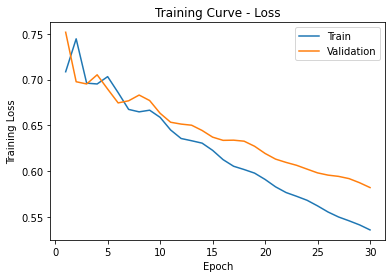

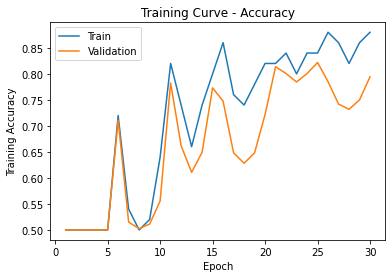

Baseline_Model(
  (embedding): Embedding(400000, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
args = AttrDict()
args_dict = {'emb_dim': 100,
             'batch_size':50, 
             'learning_rate':0.03,
             'num_epoch':30,
             'overfit':True,
             'save':False}
args.update(args_dict)

main(args)

Using device: cpu
This is epoch 1 with training loss 0.6749776130542159 and validation loss 0.6502295479178428 and train accuracy 0.7296875 and validation accuracy 0.74375
This is epoch 2 with training loss 0.6307754762470722 and validation loss 0.6101225771009922 and train accuracy 0.7871875 and validation accuracy 0.79625
This is epoch 3 with training loss 0.5945849573239684 and validation loss 0.5770035095512867 and train accuracy 0.814375 and validation accuracy 0.819375
This is epoch 4 with training loss 0.5643305416218937 and validation loss 0.5492545627057552 and train accuracy 0.82703125 and validation accuracy 0.8325
This is epoch 5 with training loss 0.5387403935194015 and validation loss 0.525753504037857 and train accuracy 0.83546875 and validation accuracy 0.840625
This is epoch 6 with training loss 0.5168794937431812 and validation loss 0.5056615527719259 and train accuracy 0.84296875 and validation accuracy 0.845
This is epoch 7 with training loss 0.4980329105630517 and 

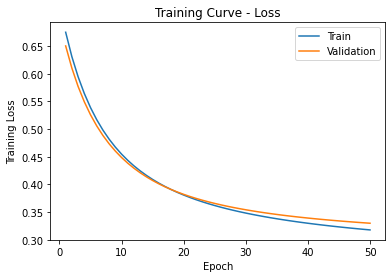

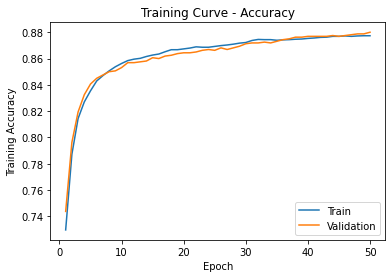

In [ ]:
args = AttrDict()
args_dict = {'emb_dim': 100,
             'batch_size':20, 
             'learning_rate':0.001,
             'num_epoch':50,
             'overfit':False,
             'save':True}
args.update(args_dict)

model = main(args)

In [ ]:
torch.manual_seed(2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                   
test_dataset = TextDataset(glove, "test")
      
test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
model = Baseline_Model(glove)
model.load_state_dict(torch.load('model_baseline.pt'))
model.eval()
  
print("The test accuracy is {}".format(get_accuracy(model, test_dataloader, device)))

Using device: cpu
The test accuracy is 0.8915


In [ ]:
param_list = []
for param in model.parameters():
  param_list.append(param)

In [ ]:
def print_closest_cosine_words(vec, n):
  dist = torch.cosine_similarity(glove.vectors, vec, dim=1)
  lst = sorted(enumerate(dist.detach().numpy()), key=lambda x:x[1], reverse=True)
  for idx, difference in lst[1:n+1]:
    print(glove.itos[idx], "\t%5.2f" % difference)

In [ ]:
print_closest_cosine_words(param_list[1], 20)

visuals 	 0.57
pleasing 	 0.56
insipid 	 0.55
flattering 	 0.55
watchable 	 0.53
cheesy 	 0.53
campy 	 0.52
cartoonish 	 0.51
laughable 	 0.51
realistic 	 0.51
disquieting 	 0.51
cartoony 	 0.51
underwhelming 	 0.51
appetizing 	 0.51
engrossing 	 0.50
oversimplified 	 0.50
nuanced 	 0.50
verbiage 	 0.50
portentous 	 0.50
gimmicky 	 0.50
